(classification2)=
# Classification II: evaluation & tuning

```{r classification2-setup, echo = FALSE, message = FALSE, warning = FALSE}
library(gridExtra)
library(cowplot)
library(stringr)
library(knitr)
library(ggplot2)

knitr::opts_chunk$set(fig.align = "center")

print_tidymodels <- function(tidymodels_object) {
  if(!is_latex_output()) {
    tidymodels_object
  } else {
    output <- capture.output(tidymodels_object)
    
    for (i in seq_along(output)) {
      if (nchar(output[i]) <= 80) {
        cat(output[i], sep = "\n")
      } else {
        cat(str_sub(output[i], start = 1, end = 80), sep = "\n")
        cat(str_sub(output[i], start = 81, end = nchar(output[i])), sep = "\n")
      }
    }
  }
}

theme_update(axis.title = element_text(size = 12)) # modify axis label size in plots 

```

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

alt.data_transformers.disable_max_rows()
# alt.renderers.enable("mimetype")

from myst_nb import glue

## Overview 
This chapter continues the introduction to predictive modeling through
classification. While the previous chapter covered training and data
preprocessing, this chapter focuses on how to evaluate the accuracy of
a classifier, as well as how to improve the classifier (where possible)
to maximize its accuracy.

## Chapter learning objectives 
By the end of the chapter, readers will be able to do the following:

- Describe what training, validation, and test data sets are and how they are used in classification.
- Split data into training, validation, and test data sets.
- Describe what a random seed is and its importance in reproducible data analysis.
- Set the random seed in R using the `set.seed` function.
- Evaluate classification accuracy in R using a validation data set and appropriate metrics.
- Execute cross-validation in R to choose the number of neighbors in a $K$-nearest neighbors classifier.
- Describe the advantages and disadvantages of the $K$-nearest neighbors classification algorithm.

## Evaluating accuracy

Sometimes our classifier might make the wrong prediction. A classifier does not
need to be right 100\% of the time to be useful, though we don't want the
classifier to make too many wrong predictions. How do we measure how "good" our
classifier is? Let's revisit the \index{breast cancer}
[breast cancer images data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) {cite:p}`streetbreastcancer`
and think about how our classifier will be used in practice. A biopsy will be
performed on a *new* patient's tumor, the resulting image will be analyzed,
and the classifier will be asked to decide whether the tumor is benign or
malignant. The key word here is *new*: our classifier is "good" if it provides
accurate predictions on data *not seen during training*. But then, how can we
evaluate our classifier without visiting the hospital to collect more
tumor images? 

The trick is to split the data into a **training set** \index{training set} and **test set** \index{test set} ({numref}`fig:06-training-test`)
and use only the **training set** when building the classifier.
Then, to evaluate the accuracy of the classifier, we first set aside the true labels from the **test set**,
and then use the classifier to predict the labels in the **test set**. If our predictions match the true
labels for the observations in the **test set**, then we have some
confidence that our classifier might also accurately predict the class
labels for new observations without known class labels.

> **Note:** If there were a golden rule of machine learning, \index{golden rule of machine learning} it might be this: 
> *you cannot use the test data to build the model!* If you do, the model gets to
> "see" the test data in advance, making it look more accurate than it really
> is. Imagine how bad it would be to overestimate your classifier's accuracy
> when predicting whether a patient's tumor is malignant or benign!

```{figure} img/training_test.jpeg
:name: fig:06-training-test
:figclass: caption-hack

Splitting the data into training and testing sets.
```

How exactly can we assess how well our predictions match the true labels for
the observations in the test set? One way we can do this is to calculate the
**prediction accuracy**. \index{prediction accuracy|see{accuracy}}\index{accuracy} This is the fraction of examples for which the
classifier made the correct prediction. To calculate this, we divide the number
of correct predictions by the number of predictions made. 

$$\mathrm{prediction \; accuracy} = \frac{\mathrm{number \; of  \; correct  \; predictions}}{\mathrm{total \;  number \;  of  \; predictions}}$$

The process for assessing if our predictions match the true labels in the 
test set is illustrated in {numref}`fig:06-ML-paradigm-test`. Note that there 
are other measures for how well classifiers perform, such as *precision* and *recall*; 
these will not be discussed here, but you will likely encounter them in other more advanced
books on this topic.

```{figure} img/ML-paradigm-test.png
:name: fig:06-ML-paradigm-test
:figclass: caption-hack

Process for splitting the data and finding the prediction accuracy.
```

(randomseeds)=
## Randomness and seeds
Beginning in this chapter, our data analyses will often involve the use
of *randomness*. \index{random} We use randomness any time we need to make a decision in our
analysis that needs to be fair, unbiased, and not influenced by human input.
For example, in this chapter, we need to split
a data set into a training set and test set to evaluate our classifier. We 
certainly do not want to choose how to split
the data ourselves by hand, as we want to avoid accidentally influencing the result
of the evaluation. So instead, we let Python *randomly* split the data.
In future chapters we will use randomness
in many other ways, e.g., to help us select a small subset of data from a larger data set, 
to pick groupings of data, and more.

However, the use of randomness runs counter to one of the main 
tenets of good data analysis practice: \index{reproducible} *reproducibility*. Recall that a reproducible
analysis produces the same result each time it is run; if we include randomness
in the analysis, would we not get a different result each time?
The trick is that in Python&mdash;and other programming languages&mdash;randomness 
is not actually random! Instead, Python uses a *random number generator* that
produces a sequence of numbers that
are completely determined by a \index{seed} \index{random seed|see{seed}}
 *seed value*. Once you set the seed value 
using the \index{seed!set.seed} `np.random.seed` function or the `random_state` argument, everything after that point may *look* random,
but is actually totally reproducible. As long as you pick the same seed
value, you get the same result!

Let's use an example to investigate how seeds work in Python. Say we want 
to randomly pick 10 numbers from 0 to 9 in Python using the `np.random.choice` \index{sample!function} function,
but we want it to be reproducible. Before using the sample function,
we call `np.random.seed`, and pass it any integer as an argument. 
Here, we pass in the number `1`.

In [2]:
import numpy as np

np.random.seed(1)
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9])

You can see that `random_numbers` is a list of 10 numbers
from 0 to 9 that, from all appearances, looks random. If 
we run the `np.random.choice` function again, we will 
get a fresh batch of 10 numbers that also look random.

In [3]:
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([2, 4, 5, 2, 4, 2, 4, 7, 7, 9])

If we want to force Python to produce the same sequences of random numbers,
we can simply call the `np.random.seed` function again with the same argument
value.

In [4]:
np.random.seed(1)
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9])

In [5]:
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([2, 4, 5, 2, 4, 2, 4, 7, 7, 9])

And if we choose 
a different value for the seed&mdash;say, 4235&mdash;we
obtain a different sequence of random numbers.

In [6]:
np.random.seed(4235)
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([8, 0, 1, 0, 0, 7, 5, 5, 3, 9])

In [7]:
random_numbers = np.random.choice(range(10), size=10, replace=True)
random_numbers

array([7, 5, 9, 5, 5, 8, 2, 8, 0, 4])

In other words, even though the sequences of numbers that Python is generating *look*
random, they are totally determined when we set a seed value! 

So what does this mean for data analysis? Well, `np.random.choice` is certainly
not the only function that uses randomness in R. Many of the functions 
that we use in `scikit-learn`, `numpy`, and beyond use randomness&mdash;many of them
without even telling you about it. So at the beginning of every data analysis you
do, right after loading packages, you should call the `np.random.seed` function and
pass it an integer that you pick.
Also note that when Python starts up, it creates its own seed to use. So if you do not
explicitly call the `np.random.seed` function in your code, your results will 
likely not be reproducible.
And finally, be careful to set the seed *only once* at the beginning of a data
analysis. Each time you set the seed, you are inserting your own human input,
thereby influencing the analysis. If you use `np.random.choice` many times
throughout your analysis, the randomness that Python uses will not look 
as random as it should.

In summary: if you want your analysis to be reproducible, i.e., produce *the same result* each time you
run it, make sure to use `np.random.seed` exactly once at the beginning of the analysis.
Different argument values in `np.random.seed` lead to different patterns of randomness, but as long as 
you pick the same argument value your result will be the same. 
In the remainder of the textbook, we will set the seed once at the beginning of each chapter.

In [8]:
# In other words, even though the sequences of numbers that R is generating *look*
# random, they are totally determined when we set a seed value! 

# So what does this mean for data analysis? Well, `sample` is certainly
# not the only function that uses randomness in R. Many of the functions 
# that we use in `tidymodels`, `tidyverse`, and beyond use randomness&mdash;many of them
# without even telling you about it. So at the beginning of every data analysis you
# do, right after loading packages, you should call the `set.seed` function and
# pass it an integer that you pick.
# Also note that when R starts up, it creates its own seed to use. So if you do not
# explicitly call the `set.seed` function in your code, your results will 
# likely not be reproducible.
# And finally, be careful to set the seed *only once* at the beginning of a data
# analysis. Each time you set the seed, you are inserting your own human input,
# thereby influencing the analysis. If you use `set.seed` many times
# throughout your analysis, the randomness that R uses will not look 
# as random as it should.

# In summary: if you want your analysis to be reproducible, i.e., produce *the same result* each time you
# run it, make sure to use `set.seed` exactly once at the beginning of the analysis.
# Different argument values in `set.seed` lead to different patterns of randomness, but as long as 
# you pick the same argument value your result will be the same. 
# In the remainder of the textbook, we will set the seed once at the beginning of each chapter.

## Evaluating accuracy with `scikit-learn`
Back to evaluating classifiers now!
In R, we can use the `tidymodels` package \index{tidymodels} not only to perform $K$-nearest neighbors
classification, but also to assess how well our classification worked. 
Let's work through an example of how to use tools from `tidymodels` to evaluate a classifier
 using the breast cancer data set from the previous chapter.
We begin the analysis by loading the packages we require,
reading in the breast cancer data,
and then making a quick scatter plot visualization \index{visualization!scatter} of
tumor cell concavity versus smoothness colored by diagnosis in {numref}`fig:06-precode`.
You will also notice that we set the random seed here at the beginning of the analysis
using the `set.seed` function, as described in Section {ref}`randomseeds`.

In [9]:
# load packages
import altair as alt
import pandas as pd

# set the seed
np.random.seed(4235)

# load data
cancer = pd.read_csv("data/unscaled_wdbc.csv")
## re-label Class 'M' as 'Malignant', and Class 'B' as 'Benign'
cancer["Class"] = cancer["Class"].apply(
    lambda x: "Malignant" if (x == "M") else "Benign"
)

# create scatter plot of tumor cell concavity versus smoothness,
# labeling the points be diagnosis class
## create a list of colors that will be used to customize the color of points
colors = ["#86bfef", "#efb13f"]

perim_concav = (
    alt.Chart(cancer)
    .mark_point(opacity=0.6, filled=True, size=40)
    .encode(
        x="Smoothness",
        y="Concavity",
        color=alt.Color("Class", scale=alt.Scale(range=colors), title="Diagnosis"),
    )
)

perim_concav

alt.Chart(...)

```{figure} data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7
:name: fig:06-precode
:figclass: caption-hack

Scatter plot of tumor cell concavity versus smoothness colored by diagnosis label.
```

### Create the train / test split

Once we have decided on a predictive question to answer and done some
preliminary exploration, the very next thing to do is to split the data into
the training and test sets. Typically, the training set is between 50% and 95% of
the data, while the test set is the remaining 5% to 50%; the intuition is that
you want to trade off between training an accurate model (by using a larger
training data set) and getting an accurate evaluation of its performance (by
using a larger test data set). Here, we will use 75% of the data for training,
and 25% for testing.

The `train_test_split` function \index{tidymodels!initial\_split} from `scikit-learn` handles the procedure of splitting
the data for us. We can specify two very important parameters when using `train_test_split` to ensure
that the accuracy estimates from the test data are reasonable. First, `shuffle=True` (default) \index{shuffling} means the data will be shuffled before splitting, which ensures that any ordering present
in the data does not influence the data that ends up in the training and testing sets.
Second, by specifying the `stratify` parameter to be the target column of the training set,
it **stratifies** the \index{stratification} data by the class label, to ensure that roughly
the same proportion of each class ends up in both the training and testing sets. For example,
in our data set, roughly 63% of the
observations are from the benign class (`B`), and 37% are from the malignant class (`M`),
so specifying `stratify` as the class column ensures that roughly 63% of the training data are benign, 
37% of the training data are malignant,
and the same proportions exist in the testing data.

Let's use the `train_test_split` function to create the training and testing sets.
We will specify that `train_size=0.75` so that 75% of our original data set ends up
in the training set. We will also set the `stratify` argument to the categorical label variable
(here, `cancer['Class']`) to ensure that the training and testing subsets contain the
right proportions of each category of observation.
Note that the `train_test_split` function uses randomness, so we shall set `random_state` to make
the split reproducible.

In [10]:
# The `initial_split` function \index{tidymodels!initial\_split} from `tidymodels` handles the procedure of splitting
# the data for us. It also applies two very important steps when splitting to ensure
# that the accuracy estimates from the test data are reasonable. First, it
# **shuffles** the \index{shuffling} data before splitting, which ensures that any ordering present
# in the data does not influence the data that ends up in the training and testing sets.
# Second, it **stratifies** the \index{stratification} data by the class label, to ensure that roughly
# the same proportion of each class ends up in both the training and testing sets. For example,
# in our data set, roughly 63% of the
# observations are from the benign class (`B`), and 37% are from the malignant class (`M`),
# so `initial_split` ensures that roughly 63% of the training data are benign, 
# 37% of the training data are malignant,
# and the same proportions exist in the testing data.

# Let's use the `initial_split` function to create the training and testing sets.
# We will specify that `prop = 0.75` so that 75% of our original data set ends up
# in the training set. We will also set the `strata` argument to the categorical label variable
# (here, `Class`) to ensure that the training and testing subsets contain the
# right proportions of each category of observation.
# The `training` and `testing` functions then extract the training and testing
# data sets into two separate data frames.
# Note that the `initial_split` function uses randomness, but since we set the 
# seed earlier in the chapter, the split will be reproducible.

In [11]:
cancer_train, cancer_test = train_test_split(
    cancer, train_size=0.75, stratify=cancer["Class"], random_state=1
)
cancer_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 164 to 284
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 426 non-null    int64  
 1   Class              426 non-null    object 
 2   Radius             426 non-null    float64
 3   Texture            426 non-null    float64
 4   Perimeter          426 non-null    float64
 5   Area               426 non-null    float64
 6   Smoothness         426 non-null    float64
 7   Compactness        426 non-null    float64
 8   Concavity          426 non-null    float64
 9   Concave_Points     426 non-null    float64
 10  Symmetry           426 non-null    float64
 11  Fractal_Dimension  426 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 43.3+ KB


In [12]:
cancer_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 357 to 332
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 143 non-null    int64  
 1   Class              143 non-null    object 
 2   Radius             143 non-null    float64
 3   Texture            143 non-null    float64
 4   Perimeter          143 non-null    float64
 5   Area               143 non-null    float64
 6   Smoothness         143 non-null    float64
 7   Compactness        143 non-null    float64
 8   Concavity          143 non-null    float64
 9   Concave_Points     143 non-null    float64
 10  Symmetry           143 non-null    float64
 11  Fractal_Dimension  143 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 14.5+ KB


In [13]:
glue("cancer_train_nrow", len(cancer_train))
glue("cancer_test_nrow", len(cancer_test))

426

143

We can see from `.info()` in \index{glimpse} the code above that the training set contains {glue:}`cancer_train_nrow` observations, 
while the test set contains {glue:}`cancer_test_nrow` observations. This corresponds to
a train / test split of 75% / 25%, as desired. Recall from Chapter {ref}`classification`
that we use the `.info()` method to view data with a large number of columns,
as it prints the data such that the columns go down the page (instead of across).

In [14]:
# We can see from `glimpse` in \index{glimpse} the code above that the training set contains `r nrow(cancer_train)`
# observations, while the test set contains `r nrow(cancer_test)` observations. This corresponds to
# a train / test split of 75% / 25%, as desired. Recall from Chapter \@ref(classification)
# that we use the `glimpse` function to view data with a large number of columns,
# as it prints the data such that the columns go down the page (instead of across).

We can use `.groupby()` and `.count()` to \index{group\_by}\index{summarize} find the percentage of malignant and benign classes 
in `cancer_train` and we see about {glue:}`cancer_train_b_prop`% of the training
data are benign and {glue:}`cancer_train_m_prop`% 
are malignant, indicating that our class proportions were roughly preserved when we split the data.

In [15]:
cancer_proportions = pd.DataFrame()
cancer_proportions['n'] = cancer_train.groupby('Class')['ID'].count()
cancer_proportions['percent'] = 100 * cancer_proportions['n'] / len(cancer_train)
cancer_proportions

,n,percent
Class,,
Benign,267,62.676056
Malignant,159,37.323944


In [16]:
glue("cancer_train_b_prop", round(cancer_proportions.iloc[0, 1]))
glue("cancer_train_m_prop", round(cancer_proportions.iloc[1, 1]))

63

37

### Preprocess the data

As we mentioned in the last chapter, $K$-nearest neighbors is sensitive to the scale of the predictors,
so we should perform some preprocessing to standardize them. An
additional consideration we need to take when doing this is that we should
create the standardization preprocessor using **only the training data**. This ensures that
our test data does not influence any aspect of our model training. Once we have
created the standardization preprocessor, we can then apply it separately to both the
training and test data sets.

Fortunately, the `Pipeline` framework (together with column transformer) from `scikit-learn` helps us handle this properly. Below we construct and prepare the preprocessor using `make_column_transformer`. Later after we construct a full `Pipeline`, we will only fit it with the training data.

In [17]:
# Fortunately, the `recipe` framework from `tidymodels` helps us handle \index{recipe}\index{recipe!step\_scale}\index{recipe!step\_center}
# this properly. Below we construct and prepare the recipe using only the training
# data (due to `data = cancer_train` in the first line).

In [18]:
cancer_preprocessor = make_column_transformer(
    (StandardScaler(), ["Smoothness", "Concavity"]),
)

### Train the classifier

Now that we have split our original data set into training and test sets, we
can create our $K$-nearest neighbors classifier with only the training set using
the technique we learned in the previous chapter. For now, we will just choose
the number $K$ of neighbors to be 3. To fit the model with only concavity and smoothness as the
predictors, we need to explicitly create `X` (predictors) and `y` (target) based on `cancer_train`.
As before we need to create a model specification, combine
the model specification and recipe into a workflow, and then finally
use `fit` with `X` and `y` to build the classifier.

In [19]:
# Now that we have split our original data set into training and test sets, we
# can create our $K$-nearest neighbors classifier with only the training set using
# the technique we learned in the previous chapter. For now, we will just choose
# the number $K$ of neighbors to be 3, and use concavity and smoothness as the
# predictors. As before we need to create a model specification, combine
# the model specification and recipe into a workflow, and then finally
# use `fit` with the training data `cancer_train` to build the classifier.

In [20]:
# hidden seed
np.random.seed(1)

knn_spec = KNeighborsClassifier(n_neighbors=3, weights="uniform")

X = cancer_train.loc[:, ["Smoothness", "Concavity"]]
y = cancer_train["Class"]

knn_fit = make_pipeline(cancer_preprocessor, knn_spec).fit(X, y)

knn_fit

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Smoothness',
                                                   'Concavity'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

### Predict the labels in the test set

Now that we have a $K$-nearest neighbors classifier object, we can use it to
predict the class labels for our test set.  We use the `pandas.concat()` to add the
column of predictions to the original test data, creating the
`cancer_test_predictions` data frame. The `Class` variable contains the true
diagnoses, while the `predicted` contains the predicted diagnoses from the
classifier.

In [21]:
# Now that we have a $K$-nearest neighbors classifier object, we can use it to
# predict the class labels for our test set.  We use the `bind_cols` \index{bind\_cols} to add the
# column of predictions to the original test data, creating the
# `cancer_test_predictions` data frame.  The `Class` variable contains the true
# diagnoses, while the `.pred_class` contains the predicted diagnoses from the
# classifier.

In [22]:
# np.random.seed(1)

cancer_test_predictions = knn_fit.predict(
    cancer_test.loc[:, ["Smoothness", "Concavity"]]
)
cancer_test_predictions = pd.concat(
    [
        pd.DataFrame(cancer_test_predictions, columns=["predicted"]),
        cancer_test.reset_index(drop=True),
    ],
    axis=1,
)  # to add the predictions column to the original test data

cancer_test_predictions

,predicted,ID,Class,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_Points,Symmetry,Fractal_Dimension
0,Benign,901028,Benign,13.870,16.21,88.52,593.7,0.08743,0.05492,0.015020,0.020880,0.1424,0.05883
1,Benign,901041,Benign,13.300,21.57,85.24,546.1,0.08582,0.06373,0.033440,0.024240,0.1815,0.05696
2,Malignant,8810703,Malignant,28.110,18.47,188.50,2499.0,0.11420,0.15160,0.320100,0.159500,0.1648,0.05525
3,Benign,91813702,Benign,12.340,12.27,78.94,468.5,0.09003,0.06307,0.029580,0.026470,0.1689,0.05808
4,Benign,8510824,Benign,9.504,12.44,60.34,273.9,0.10240,0.06492,0.029560,0.020760,0.1815,0.06905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Benign,9010877,Benign,13.400,16.95,85.48,552.4,0.07937,0.05696,0.021810,0.014730,0.1650,0.05701
139,Benign,908469,Benign,14.860,16.94,94.89,673.7,0.08924,0.07074,0.033460,0.028770,0.1573,0.05703
140,Benign,892399,Benign,10.510,23.09,66.85,334.2,0.10150,0.06797,0.024950,0.018750,0.1695,0.06556
141,Benign,913512,Benign,11.680,16.17,75.49,420.5,0.11280,0.09263,0.042790,0.031320,0.1853,0.06401


### Compute the accuracy

Finally, we can assess our classifier's accuracy. To do this we use the `score` method 
from `scikit-learn` to get the statistics about the quality of our model, specifying
the `X` and `y` arguments based on `cancer_test`.

In [23]:
# Finally, we can assess our classifier's accuracy. To do this we use the `metrics` function \index{tidymodels!metrics}
# from `tidymodels` to get the statistics about the quality of our model, specifying
# the `truth` and `estimate` arguments:

In [24]:
# np.random.seed(1)

X_test = cancer_test.loc[:, ["Smoothness", "Concavity"]]
y_test = cancer_test["Class"]

cancer_acc_1 = knn_fit.score(X_test, y_test)

cancer_acc_1

0.8741258741258742

In [25]:
glue("cancer_acc_1", round(100*cancer_acc_1))

87

In [26]:
# In the metrics data frame, we filtered the `.metric` column since we are 
# interested in the `accuracy` row. Other entries involve more advanced metrics that
# are beyond the scope of this book. Looking at the value of the `.estimate` variable
#  shows that the estimated accuracy of the classifier on the test data 
# was `r round(100*cancer_acc_1$.estimate, 0)`%.

The output shows that the estimated accuracy of the classifier on the test data 
was {glue:}`cancer_acc_1`%.

We can also look at the *confusion matrix* for the classifier as a `numpy` array using the `confusion_matrix` function:

In [27]:
# np.random.seed(1)

confusion = confusion_matrix(
    cancer_test_predictions["Class"],
    cancer_test_predictions["predicted"],
    labels=knn_fit.classes_,
)

confusion

array([[82,  8],
       [10, 43]])

It is hard for us to interpret the confusion matrix as shown above. We could use the `ConfusionMatrixDisplay` function of the `scikit-learn` package to plot the confusion matrix.

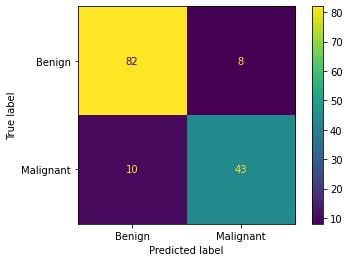

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion, display_labels=knn_fit.classes_
)
confusion_display.plot()

In [33]:
glue("confu11", confusion[1, 1])
glue("confu00", confusion[0, 0])
glue("confu10", confusion[1, 0])
glue("confu01", confusion[0, 1])
glue("confu11_00", confusion[1, 1] + confusion[0, 0])
glue("confu10_11", confusion[1, 0] + confusion[1, 1])
glue("confu_fal_neg", round(100 * confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])))

43

82

10

8

125

53

19

The confusion matrix shows {glue:}`confu11` observations were correctly predicted 
as malignant, and {glue:}`confu00` were correctly predicted as benign. Therefore the classifier labeled 
{glue:}`confu11` + {glue:}`confu00` = {glue:}`confu11_00` observations 
correctly. It also shows that the classifier made some mistakes; in particular,
it classified {glue:}`confu10` observations as benign when they were truly malignant,
and {glue:}`confu01` observations as malignant when they were truly benign.

### Critically analyze performance

We now know that the classifier was {glue:}`cancer_acc_1`% accurate
on the test data set. That sounds pretty good! Wait, *is* it good? 
Or do we need something higher?

In general, what a *good* value for accuracy \index{accuracy!assessment} is depends on the application.
 For instance, suppose you are predicting whether a tumor is benign or malignant
 for a type of tumor that is benign 99% of the time. It is very easy to obtain 
 a 99% accuracy just by guessing benign for every observation. In this case, 
 99% accuracy is probably not good enough.  And beyond just accuracy,
sometimes the *kind* of mistake the classifier makes is important as well. In
the previous example, it might be very bad for the classifier to predict
"benign" when the true class is "malignant", as this might result in a patient
not receiving appropriate medical attention. On the other hand, it might be
less bad for the classifier to guess "malignant" when the true class is
"benign", as the patient will then likely see a doctor who can provide an
expert diagnosis. This is why it is important not only to look at accuracy, but
also the confusion matrix.

However, there is always an easy baseline that you can compare to for any
classification problem: the *majority classifier*. The majority classifier \index{classification!majority}
*always* guesses the majority class label from the training data, regardless of
the predictor variables' values.  It helps to give you a sense of
scale when considering accuracies. If the majority classifier obtains a 90%
accuracy on a problem, then you might hope for your $K$-nearest neighbors
classifier to do better than that. If your classifier provides a significant
improvement upon the majority classifier, this means that at least your method
is extracting some useful information from your predictor variables.  Be
careful though: improving on the majority classifier does not *necessarily*
mean the classifier is working well enough for your application. 

As an example, in the breast cancer data, recall the proportions of benign and malignant
observations in the training data are as follows:

In [30]:
cancer_proportions

,n,percent
Class,,
Benign,267,62.676056
Malignant,159,37.323944


Since the benign class represents the majority of the training data,
the majority classifier would *always* predict that a new observation
is benign. The estimated accuracy of the majority classifier is usually
fairly close to the majority class proportion in the training data.
In this case, we would suspect that the majority classifier will have 
an accuracy of around {glue:}`cancer_train_b_prop`%.
The $K$-nearest neighbors classifier we built does quite a bit better than this, 
with an accuracy of {glue:}`cancer_acc_1`%. 
This means that from the perspective of accuracy,
the $K$-nearest neighbors classifier improved quite a bit on the basic
majority classifier. Hooray! But we still need to be cautious; in 
this application, it is likely very important not to misdiagnose any malignant tumors to avoid missing
patients who actually need medical care. The confusion matrix above shows
that the classifier does, indeed, misdiagnose a significant number of malignant tumors as benign ({glue:}`confu10` out of {glue:}`confu10_11` malignant tumors, or {glue:}`confu_fal_neg`%!).
Therefore, even though the accuracy improved upon the majority classifier,
our critical analysis suggests that this classifier may not have appropriate performance
for the application.

## Tuning the classifier

The vast majority of predictive models in statistics and machine learning have
*parameters*. A *parameter* \index{parameter}\index{tuning parameter|see{parameter}}
is a number you have to pick in advance that determines
some aspect of how the model behaves. For example, in the $K$-nearest neighbors
classification algorithm, $K$ is a parameter that we have to pick
that determines how many neighbors participate in the class vote. 
By picking different values of $K$, we create different classifiers 
that make different predictions.

So then, how do we pick the *best* value of $K$, i.e., *tune* the model? 
And is it possible to make this selection in a principled way?  Ideally, 
we want somehow to maximize the performance of our classifier on data *it
hasn't seen yet*. But we cannot use our test data set in the process of building
our model. So we will play the same trick we did before when evaluating
our classifier: we'll split our *training data itself* into two subsets,
use one to train the model, and then use the other to evaluate it.
In this section, we will cover the details of this procedure, as well as 
how to use it to help you pick a good parameter value for your classifier.

**And remember:** don't touch the test set during the tuning process. Tuning is a part of model training!

### Cross-validation

The first step in choosing the parameter $K$ is to be able to evaluate the 
classifier using only the training data. If this is possible, then we can compare
the classifier's performance for different values of $K$&mdash;and pick the best&mdash;using 
only the training data. As suggested at the beginning of this section, we will
accomplish this by splitting the training data, training on one subset, and evaluating
on the other. The subset of training data used for evaluation is often called the **validation set**. \index{validation set}

There is, however, one key difference from the train/test split
that we performed earlier. In particular, we were forced to make only a *single split*
of the data. This is because at the end of the day, we have to produce a single classifier.
If we had multiple different splits of the data into training and testing data,
we would produce multiple different classifiers.
But while we are tuning the classifier, we are free to create multiple classifiers
based on multiple splits of the training data, evaluate them, and then choose a parameter
value based on __*all*__ of the different results. If we just split our overall training
data *once*, our best parameter choice will depend strongly on whatever data
was lucky enough to end up in the validation set. Perhaps using multiple
different train/validation splits, we'll get a better estimate of accuracy,
which will lead to a better choice of the number of neighbors $K$ for the
overall set of training data. 

Let's investigate this idea in R! In particular, we will generate five different train/validation
splits of our overall training data, train five different $K$-nearest neighbors
models, and evaluate their accuracy. We will start with just a single
split.

```{r 06-five-splits-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-five-splits}
# create the 25/75 split of the training data into training and validation
cancer_split <- initial_split(cancer_train, prop = 0.75, strata = Class)
cancer_subtrain <- training(cancer_split)
cancer_validation <- testing(cancer_split)

# recreate the standardization recipe from before 
# (since it must be based on the training data)
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, 
                        data = cancer_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit(data = cancer_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_fit, cancer_validation) |>
  bind_cols(cancer_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = Class, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc
```

```{r 06-five-splits-loop, echo = FALSE, message = FALSE, warning = FALSE}
accuracies <- c()
for (i in 1:5) {
  set.seed(i) # makes the random selection of rows reproducible

  # create the 25/75 split of the training data into training and validation
  cancer_split <- initial_split(cancer_train, prop = 0.75, strata = Class)
  cancer_subtrain <- training(cancer_split)
  cancer_validation <- testing(cancer_split)

  # recreate the standardization recipe from before 
  # (since it must be based on the training data)
  cancer_recipe <- recipe(Class ~ Smoothness + Concavity, 
                          data = cancer_subtrain) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

  # fit the knn model (we can reuse the old knn_spec model from before)
  knn_fit <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec) |>
    fit(data = cancer_subtrain)

  # get predictions on the validation data
  validation_predicted <- predict(knn_fit, cancer_validation) |>
    bind_cols(cancer_validation)

  # compute the accuracy
  acc_ <- validation_predicted |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
  accuracies <- append(accuracies, acc_)
}
```

The accuracy estimate using this split is `r round(100*acc,1)`%.
Now we repeat the above code 4 more times, which generates 4 more splits.
Therefore we get five different shuffles of the data, and therefore five different values for
accuracy: `r sprintf("%.1f%%", round(100*accuracies,1))`. None of these values are
necessarily "more correct" than any other; they're
just five estimates of the true, underlying accuracy of our classifier built
using our overall training data. We can combine the estimates by taking their
average (here `r round(100*mean(accuracies),0)`%) to try to get a single assessment of our
classifier's accuracy; this has the effect of reducing the influence of any one
(un)lucky validation set on the estimate. 

In practice, we don't use random splits, but rather use a more structured
splitting procedure so that each observation in the data set is used in a
validation set only a single time. The name for this strategy is 
**cross-validation**.  In **cross-validation**, \index{cross-validation} we split our **overall training
data** into $C$ evenly sized chunks. Then, iteratively use $1$ chunk as the
**validation set** and combine the remaining $C-1$ chunks 
as the **training set**. 
This procedure is shown in Figure \@ref(fig:06-cv-image).
Here, $C=5$ different chunks of the data set are used,
resulting in 5 different choices for the **validation set**; we call this
*5-fold* cross-validation.

```{r 06-cv-image, echo = FALSE, message = FALSE, warning = FALSE, fig.cap = "5-fold cross-validation.", fig.pos = "H", out.extra="", fig.retina = 2, out.width = "100%"}
knitr::include_graphics("img/cv.png")
```

To perform 5-fold cross-validation in R with `tidymodels`, we use another
function: `vfold_cv`. \index{tidymodels!vfold\_cv}\index{cross-validation!vfold\_cv} This function splits our training data into `v` folds
automatically. We set the `strata` argument to the categorical label variable
(here, `Class`) to ensure that the training and validation subsets contain the
right proportions of each category of observation.

```{r 06-vfold-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(14) 
```

```{r 06-vfold}
cancer_vfold <- vfold_cv(cancer_train, v = 5, strata = Class)
cancer_vfold
```

Then, when we create our data analysis workflow, we use the `fit_resamples` function \index{cross-validation!fit\_resamples}\index{tidymodels!fit\_resamples}
instead of the `fit` function for training. This runs cross-validation on each
train/validation split. 

```{r 06-vfold-workflow-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-vfold-workflow}
# recreate the standardization recipe from before 
# (since it must be based on the training data)
cancer_recipe <- recipe(Class ~ Smoothness + Concavity, 
                        data = cancer_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = cancer_vfold)

knn_fit
```

The `collect_metrics` \index{tidymodels!collect\_metrics}\index{cross-validation!collect\_metrics} function is used to aggregate the *mean* and *standard error*
of the classifier's validation accuracy across the folds. You will find results
related to the accuracy in the row with `accuracy` listed under the `.metric` column. 
You should consider the mean (`mean`) to be the estimated accuracy, while the standard 
error (`std_err`) is a measure of how uncertain we are in the mean value. A detailed treatment of this
is beyond the scope of this chapter; but roughly, if your estimated mean is `r round(filter(collect_metrics(knn_fit), .metric == "accuracy")$mean,2)` and standard
error is `r round(filter(collect_metrics(knn_fit), .metric == "accuracy")$std_err,2)`, you can expect the *true* average accuracy of the 
classifier to be somewhere roughly between `r (round(filter(collect_metrics(knn_fit), .metric == "accuracy")$mean,2) - round(filter(collect_metrics(knn_fit), .metric == "accuracy")$std_err,2))*100`% and `r (round(filter(collect_metrics(knn_fit), .metric == "accuracy")$mean,2) + round(filter(collect_metrics(knn_fit), .metric == "accuracy")$std_err,2))*100`% (although it may
fall outside this range). You may ignore the other columns in the metrics data frame,
as they do not provide any additional insight.
You can also ignore the entire second row with `roc_auc` in the `.metric` column,
as it is beyond the scope of this book.

```{r 06-vfold-metrics}
knn_fit |> 
  collect_metrics() 
```

We can choose any number of folds, and typically the more we use the better our
accuracy estimate will be (lower standard error). However, we are limited 
by computational power: the
more folds we choose, the  more computation it takes, and hence the more time
it takes to run the analysis. So when you do cross-validation, you need to
consider the size of the data, the speed of the algorithm (e.g., $K$-nearest
neighbors), and the speed of your computer. In practice, this is a 
trial-and-error process, but typically $C$ is chosen to be either 5 or 10. Here 
we will try 10-fold cross-validation to see if we get a lower standard error:

```{r 06-10-fold}
cancer_vfold <- vfold_cv(cancer_train, v = 10, strata = Class)

vfold_metrics <- workflow() |>
                  add_recipe(cancer_recipe) |>
                  add_model(knn_spec) |>
                  fit_resamples(resamples = cancer_vfold) |>
                  collect_metrics()

vfold_metrics
```
In this case, using 10-fold instead of 5-fold cross validation did reduce the standard error, although
by only an insignificant amount. In fact, due to the randomness in how the data are split, sometimes
you might even end up with a *higher* standard error when increasing the number of folds!
We can make the reduction in standard error more dramatic by increasing the number of folds 
by a large amount. In the following code we show the result when $C = 50$; 
picking such a large number of folds often takes a long time to run in practice, 
so we usually stick to 5 or 10.

```{r 06-50-fold-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-50-fold}
cancer_vfold_50 <- vfold_cv(cancer_train, v = 50, strata = Class)

vfold_metrics_50 <- workflow() |>
                  add_recipe(cancer_recipe) |>
                  add_model(knn_spec) |>
                  fit_resamples(resamples = cancer_vfold_50) |>
                  collect_metrics()
vfold_metrics_50
```

### Parameter value selection

Using 5- and 10-fold cross-validation, we have estimated that the prediction
accuracy of our classifier is somewhere around `r round(100*(vfold_metrics |> filter(.metric == "accuracy"))$mean,0)`%. 
Whether that is good or not
depends entirely on the downstream application of the data analysis. In the
present situation, we are trying to predict a tumor diagnosis, with expensive,
damaging chemo/radiation therapy or patient death as potential consequences of
misprediction. Hence, we might like to 
do better than `r round(100*(vfold_metrics |> filter(.metric == "accuracy"))$mean,0)`% for this application.  

In order to improve our classifier, we have one choice of parameter: the number of
neighbors, $K$. Since cross-validation helps us evaluate the accuracy of our
classifier, we can use cross-validation to calculate an accuracy for each value
of $K$ in a reasonable range, and then pick the value of $K$ that gives us the
best accuracy. The `tidymodels` package collection provides a very simple
syntax for tuning models: each parameter in the model to be tuned should be specified
as `tune()` in the model specification rather than given a particular value.

```{r 06-range-cross-val}
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
```

Then instead of using `fit` or `fit_resamples`, we will use the `tune_grid` function \index{cross-validation!tune\_grid}\index{tidymodels!tune\_grid}
to fit the model for each value in a range of parameter values. 
In particular, we first create a data frame with a `neighbors`
variable that contains the sequence of values of $K$ to try; below we create the `k_vals`
data frame with the `neighbors` variable containing values from 1 to 100 (stepping by 5) using 
the `seq` function.
Then we pass that data frame to the `grid` argument of `tune_grid`.

```{r 06-range-cross-val-2-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-range-cross-val-2}
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cancer_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies
```

We can decide which number of neighbors is best by plotting the accuracy versus $K$,
as shown in Figure \@ref(fig:06-find-k).

```{r 06-find-k,  fig.height = 3.5, fig.width = 4, fig.cap= "Plot of estimated accuracy versus the number of neighbors."}
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k
```

Setting the number of 
neighbors to $K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors`
provides the highest accuracy (`r (accuracies |> arrange(desc(mean)) |> slice(1) |> pull(mean) |> round(4))*100`%). But there is no exact or perfect answer here;
any selection from $K = 30$ and $60$ would be reasonably justified, as all
of these differ in classifier accuracy by a small amount. Remember: the
values you see on this plot are *estimates* of the true accuracy of our
classifier. Although the 
$K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors` value is 
higher than the others on this plot,
that doesn't mean the classifier is actually more accurate with this parameter
value! Generally, when selecting $K$ (and other parameters for other predictive
models), we are looking for a value where:

- we get roughly optimal accuracy, so that our model will likely be accurate;
- changing the value to a nearby one (e.g., adding or subtracting a small number) doesn't decrease accuracy too much, so that our choice is reliable in the presence of uncertainty;
- the cost of training the model is not prohibitive (e.g., in our situation, if $K$ is too large, predicting becomes expensive!).

We know that $K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors` 
provides the highest estimated accuracy. Further, Figure \@ref(fig:06-find-k) shows that the estimated accuracy 
changes by only a small amount if we increase or decrease $K$ near $K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors`.
And finally, $K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors` does not create a prohibitively expensive
computational cost of training. Considering these three points, we would indeed select
$K =$ `r (accuracies |> arrange(desc(mean)) |> head(1))$neighbors` for the classifier.

### Under/Overfitting

To build a bit more intuition, what happens if we keep increasing the number of
neighbors $K$? In fact, the accuracy actually starts to decrease! 
Let's specify a much larger range of values of $K$ to try in the `grid` 
argument of `tune_grid`. Figure \@ref(fig:06-lots-of-ks) shows a plot of estimated accuracy as 
we vary $K$ from 1 to almost the number of observations in the data set.

```{r 06-lots-of-ks-seed, message = FALSE, echo = FALSE, warning = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-lots-of-ks, message = FALSE, fig.height = 3.5, fig.width = 4, fig.cap="Plot of accuracy estimate versus number of neighbors for many K values."}
k_lots <- tibble(neighbors = seq(from = 1, to = 385, by = 10))

knn_results <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cancer_vfold, grid = k_lots) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k_lots
```

**Underfitting:** \index{underfitting!classification} What is actually happening to our classifier that causes
this? As we increase the number of neighbors, more and more of the training
observations (and those that are farther and farther away from the point) get a
"say" in what the class of a new observation is. This causes a sort of
"averaging effect" to take place, making the boundary between where our
classifier would predict a tumor to be malignant versus benign to smooth out
and become *simpler.* If you take this to the extreme, setting $K$ to the total
training data set size, then the classifier will always predict the same label
regardless of what the new observation looks like. In general, if the model
*isn't influenced enough* by the training data, it is said to **underfit** the
data.

**Overfitting:** \index{overfitting!classification} In contrast, when we decrease the number of neighbors, each
individual data point has a stronger and stronger vote regarding nearby points.
Since the data themselves are noisy, this causes a more "jagged" boundary
corresponding to a *less simple* model.  If you take this case to the extreme,
setting $K = 1$, then the classifier is essentially just matching each new
observation to its closest neighbor in the training data set. This is just as
problematic as the large $K$ case, because the classifier becomes unreliable on
new data: if we had a different training set, the predictions would be
completely different.  In general, if the model *is influenced too much* by the
training data, it is said to **overfit** the data.

```{r 06-decision-grid-K, echo = FALSE, message = FALSE, fig.height = 10, fig.width = 10, fig.pos = "H", out.extra="", fig.cap = "Effect of K in overfitting and underfitting."}
ks <- c(1, 7, 20, 300)
plots <- list()

for (i in 1:length(ks)) {
  knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                               neighbors = ks[[i]]) |>
    set_engine("kknn") |>
    set_mode("classification")

  knn_fit <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec) |>
    fit(data = cancer_train)

  # create a prediction pt grid
  smo_grid <- seq(min(cancer_train$Smoothness), 
                  max(cancer_train$Smoothness), 
                  length.out = 100)
  con_grid <- seq(min(cancer_train$Concavity), 
                  max(cancer_train$Concavity), 
                  length.out = 100)
  scgrid <- as_tibble(expand.grid(Smoothness = smo_grid, 
                                  Concavity = con_grid))
  knnPredGrid <- predict(knn_fit, scgrid)
  prediction_table <- bind_cols(knnPredGrid, scgrid) |> 
    rename(Class = .pred_class)

  # plot
  plots[[i]] <-
    ggplot() +
    geom_point(data = cancer_train, 
               mapping = aes(x = Smoothness, 
                             y = Concavity, 
                             color = Class), 
               alpha = 0.75) +
    geom_point(data = prediction_table, 
               mapping = aes(x = Smoothness, 
                             y = Concavity, 
                             color = Class), 
               alpha = 0.02, 
               size = 5.) +
    labs(color = "Diagnosis") +
    ggtitle(paste("K = ", ks[[i]])) +
    scale_color_manual(labels = c("Malignant", "Benign"), 
                       values = c("orange2", "steelblue2"))  +
  theme(text = element_text(size = 18), axis.title=element_text(size=18)) 
  }

p_no_legend <- lapply(plots, function(x) x + theme(legend.position = "none"))
legend <- get_legend(plots[[1]] + theme(legend.position = "bottom"))
p_grid <- plot_grid(plotlist = p_no_legend, ncol = 2)
plot_grid(p_grid, legend, ncol = 1, rel_heights = c(1, 0.2))
```

Both overfitting and underfitting are problematic and will lead to a model 
that does not generalize well to new data. When fitting a model, we need to strike
a balance between the two. You can see these two effects in Figure 
\@ref(fig:06-decision-grid-K), which shows how the classifier changes as 
we set the number of neighbors $K$ to 1, 7, 20, and 300.

## Summary

Classification algorithms use one or more quantitative variables to predict the
value of another categorical variable. In particular, the $K$-nearest neighbors algorithm 
does this by first finding the $K$ points in the training data nearest
to the new observation, and then returning the majority class vote from those
training observations. We can evaluate a classifier by splitting the data
randomly into a training and test data set, using the training set to build the
classifier, and using the test set to estimate its accuracy. Finally, we
can tune the classifier (e.g., select the number of neighbors $K$ in $K$-NN)
by maximizing estimated accuracy via cross-validation. The overall 
process is summarized in Figure \@ref(fig:06-overview).

```{r 06-overview, echo = FALSE, message = FALSE, warning = FALSE, fig.pos = "H", out.extra="", fig.cap = "Overview of KNN classification.", fig.retina = 2, out.width = "100%"}
knitr::include_graphics("img/train-test-overview.jpeg")
```

The overall workflow for performing $K$-nearest neighbors classification using `tidymodels` is as follows:
\index{tidymodels}\index{recipe}\index{cross-validation}\index{K-nearest neighbors!classification}\index{classification}

1. Use the `initial_split` function to split the data into a training and test set. Set the `strata` argument to the class label variable. Put the test set aside for now.
2. Use the `vfold_cv` function to split up the training data for cross-validation.
3. Create a `recipe` that specifies the class label and predictors, as well as preprocessing steps for all variables. Pass the training data as the `data` argument of the recipe.
4. Create a `nearest_neighbors` model specification, with `neighbors = tune()`.
5. Add the recipe and model specification to a `workflow()`, and use the `tune_grid` function on the train/validation splits to estimate the classifier accuracy for a range of $K$ values.
6. Pick a value of $K$ that yields a high accuracy estimate that doesn't change much if you change $K$ to a nearby value.
7. Make a new model specification for the best parameter value (i.e., $K$), and retrain the classifier using the `fit` function.
8. Evaluate the estimated accuracy of the classifier on the test set using the `predict` function.

In these last two chapters, we focused on the $K$-nearest neighbor algorithm, 
but there are many other methods we could have used to predict a categorical label. 
All algorithms have their strengths and weaknesses, and we summarize these for 
the $K$-NN here.

**Strengths:** $K$-nearest neighbors classification

1. is a simple, intuitive algorithm,
2. requires few assumptions about what the data must look like, and
3. works for binary (two-class) and multi-class (more than 2 classes) classification problems.

**Weaknesses:** $K$-nearest neighbors classification

1. becomes very slow as the training data gets larger,
2. may not perform well with a large number of predictors, and
3. may not perform well when classes are imbalanced.

## Predictor variable selection

> **Note:** This section is not required reading for the remainder of the textbook. It is included for those readers 
> interested in learning how irrelevant variables can influence the performance of a classifier, and how to
> pick a subset of useful variables to include as predictors.

Another potentially important part of tuning your classifier is to choose which
variables from your data will be treated as predictor variables. Technically, you can choose
anything from using a single predictor variable to using every variable in your
data; the $K$-nearest neighbors algorithm accepts any number of
predictors. However, it is **not** the case that using more predictors always
yields better predictions! In fact, sometimes including irrelevant predictors \index{irrelevant predictors} can
actually negatively affect classifier performance.

### The effect of irrelevant predictors

Let's take a look at an example where $K$-nearest neighbors performs
worse when given more predictors to work with. In this example, we modified
the breast cancer data to have only the `Smoothness`, `Concavity`, and
`Perimeter` variables from the original data. Then, we added irrelevant
variables that we created ourselves using a random number generator.
The irrelevant variables each take a value of 0 or 1 with equal probability for each observation, regardless
of what the value `Class` variable takes. In other words, the irrelevant variables have 
no meaningful relationship with the `Class` variable.

```{r 06-irrelevant-gendata, echo = FALSE, warning = FALSE}
set.seed(4)
cancer_irrelevant <- cancer |> select(Class, Smoothness, Concavity, Perimeter)

for (i in 1:500) {
    # create column
    col = (sample(2, size=nrow(cancer_irrelevant), replace=TRUE)-1)
    cancer_irrelevant <- cancer_irrelevant |> 
	add_column( !!paste("Irrelevant", i, sep="") := col)
}
```

```{r 06-irrelevant-printdata, warning = FALSE}
cancer_irrelevant |> 
      select(Class, Smoothness, Concavity, Perimeter, Irrelevant1, Irrelevant2)
```

Next, we build a sequence of $K$-NN classifiers that include `Smoothness`,
`Concavity`, and `Perimeter` as predictor variables, but also increasingly many irrelevant
variables. In particular, we create 6 data sets with 0, 5, 10, 15, 20, and 40 irrelevant predictors.
Then we build a model, tuned via 5-fold cross-validation, for each data set.
Figure \@ref(fig:06-performance-irrelevant-features) shows
the estimated cross-validation accuracy versus the number of irrelevant predictors.  As
we add more irrelevant predictor variables, the estimated accuracy of our
classifier decreases. This is because the irrelevant variables add a random
amount to the distance between each pair of observations; the more irrelevant
variables there are, the more (random) influence they have, and the more they
corrupt the set of nearest neighbors that vote on the class of the new
observation to predict.  

```{r 06-performance-irrelevant-features, echo = FALSE, warning = FALSE, fig.retina = 2, out.width = "65%", fig.cap = "Effect of inclusion of irrelevant predictors."}
# get accuracies after including k irrelevant features
ks <- c(0, 5, 10, 15, 20, 40)
fixedaccs <- list()
accs <- list()
nghbrs <- list()

for (i in 1:length(ks)) {
  knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                               neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

  cancer_irrelevant_subset <- cancer_irrelevant |> select(1:(3+ks[[i]]))

  cancer_vfold <- vfold_cv(cancer_irrelevant_subset, v = 5, strata = Class)

  cancer_recipe <- recipe(Class ~ ., data = cancer_irrelevant_subset) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())
  
  res <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = 20) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1)
  accs[[i]] <- res$mean
  nghbrs[[i]] <- res$neighbors

  knn_spec_fixed <- nearest_neighbor(weight_func = "rectangular", 
                                     neighbors = 3) |>
     set_engine("kknn") |>
     set_mode("classification")

  res <- workflow() |>
    add_recipe(cancer_recipe) |>
    add_model(knn_spec_fixed) |>
    tune_grid(resamples = cancer_vfold, grid = 1) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1)
  fixedaccs[[i]] <- res$mean
}
accs <- accs |> unlist()
nghbrs <- nghbrs |> unlist()
fixedaccs <- fixedaccs |> unlist()

## get accuracy if we always just guess the most frequent label
#base_acc <- cancer_irrelevant |>
#                group_by(Class) |>
#                summarize(n = n()) |>
#                mutate(frac = n/sum(n)) |>
#                summarize(mx = max(frac)) |>
#                select(mx)
#base_acc <- base_acc$mx |> unlist()

# plot
res <- tibble(ks = ks, accs = accs, fixedaccs = fixedaccs, nghbrs = nghbrs)
#res <- res |> mutate(base_acc = base_acc)
#plt_irrelevant_accuracies <- res |>
#  ggplot() +
#  geom_line(mapping = aes(x=ks, y=accs, linetype="Tuned KNN")) +
#  geom_hline(data=res, mapping=aes(yintercept=base_acc, linetype="Always Predict Benign")) +
#  labs(x = "Number of Irrelevant Predictors", y = "Model Accuracy Estimate") + 
#  scale_linetype_manual(name="Method", values = c("dashed", "solid"))

plt_irrelevant_accuracies <- ggplot(res) +
              geom_line(mapping = aes(x=ks, y=accs)) +
              labs(x = "Number of Irrelevant Predictors", 
                   y = "Model Accuracy Estimate") + 
  theme(text = element_text(size = 18), axis.title=element_text(size=18)) 

plt_irrelevant_accuracies
```

Although the accuracy decreases as expected, one surprising thing about 
Figure \@ref(fig:06-performance-irrelevant-features) is that it shows that the method
still outperforms the baseline majority classifier (with about `r round(cancer_propn_1[1,1], 0)`% accuracy) 
even with 40 irrelevant variables.
How could that be? Figure \@ref(fig:06-neighbors-irrelevant-features) provides the answer:
the tuning procedure for the $K$-nearest neighbors classifier combats the extra randomness from the irrelevant variables 
by increasing the number of neighbors. Of course, because of all the extra noise in the data from the irrelevant
variables, the number of neighbors does not increase smoothly; but the general trend is increasing.
Figure \@ref(fig:06-fixed-irrelevant-features) corroborates
this evidence; if we fix the number of neighbors to $K=3$, the accuracy falls off more quickly.

```{r 06-neighbors-irrelevant-features, echo = FALSE, warning = FALSE, fig.retina = 2, out.width = "65%", fig.cap = "Tuned number of neighbors for varying number of irrelevant predictors."}
plt_irrelevant_nghbrs <- ggplot(res) +
              geom_line(mapping = aes(x=ks, y=nghbrs)) +
              labs(x = "Number of Irrelevant Predictors", 
                   y = "Number of neighbors") + 
  theme(text = element_text(size = 18), axis.title=element_text(size=18)) 

plt_irrelevant_nghbrs
```

```{r 06-fixed-irrelevant-features, echo = FALSE, warning = FALSE, fig.retina = 2, out.width = "75%", fig.cap = "Accuracy versus number of irrelevant predictors for tuned and untuned number of neighbors."}
res_tmp <- res %>% pivot_longer(cols=c("accs", "fixedaccs"), 
                                names_to="Type", 
                                values_to="accuracy")

plt_irrelevant_nghbrs <- ggplot(res_tmp) +
              geom_line(mapping = aes(x=ks, y=accuracy, color=Type)) +
              labs(x = "Number of Irrelevant Predictors", y = "Accuracy") + 
              scale_color_discrete(labels= c("Tuned K", "K = 3")) + 
  theme(text = element_text(size = 17), axis.title=element_text(size=17)) 

plt_irrelevant_nghbrs
```

### Finding a good subset of predictors

So then, if it is not ideal to use all of our variables as predictors without consideration, how 
do we choose which variables we *should* use?  A simple method is to rely on your scientific understanding
of the data to tell you which variables are not likely to be useful predictors. For example, in the cancer
data that we have been studying, the `ID` variable is just a unique identifier for the observation.
As it is not related to any measured property of the cells, the `ID` variable should therefore not be used
as a predictor. That is, of course, a very clear-cut case. But the decision for the remaining variables 
is less obvious, as all seem like reasonable candidates. It 
is not clear which subset of them will create the best classifier. One could use visualizations and
other exploratory analyses to try to help understand which variables are potentially relevant, but
this process is both time-consuming and error-prone when there are many variables to consider.
Therefore we need a more systematic and programmatic way of choosing variables. 
This is a very difficult problem to solve in
general, and there are a number of methods that have been developed that apply
in particular cases of interest. Here we will discuss two basic
selection methods as an introduction to the topic. See the additional resources at the end of
this chapter to find out where you can learn more about variable selection, including more advanced methods.

The first idea you might think of for a systematic way to select predictors
is to try all possible subsets of predictors and then pick the set that results in the "best" classifier.
This procedure is indeed a well-known variable selection method referred to 
as *best subset selection* [@bealesubset; @hockingsubset]. \index{variable selection!best subset}\index{predictor selection|see{variable selection}}
In particular, you

1. create a separate model for every possible subset of predictors,
2. tune each one using cross-validation, and
3. pick the subset of predictors that gives you the highest cross-validation accuracy.  

Best subset selection is applicable to any classification method ($K$-NN or otherwise).
However, it becomes very slow when you have even a moderate
number of predictors to choose from (say, around 10). This is because the number of possible predictor subsets
grows very quickly with the number of predictors, and you have to train the model (itself
a slow process!) for each one. For example, if we have $2$ predictors&mdash;let's call
them A and B&mdash;then we have 3 variable sets to try: A alone, B alone, and finally A
and B together. If we have $3$ predictors&mdash;A, B, and C&mdash;then we have 7
to try: A, B, C, AB, BC, AC, and ABC. In general, the number of models
we have to train for $m$ predictors is $2^m-1$; in other words, when we 
get to $10$ predictors we have over *one thousand* models to train, and 
at $20$ predictors we have over *one million* models to train! 
So although it is a simple method, best subset selection is usually too computationally 
expensive to use in practice.

Another idea is to iteratively build up a model by adding one predictor variable 
at a time. This method&mdash;known as *forward selection* [@forwardefroymson; @forwarddraper]&mdash;is also widely \index{variable selection!forward}
applicable and fairly straightforward. It involves the following steps:

1. Start with a model having no predictors.
2. Run the following 3 steps until you run out of predictors:
    1. For each unused predictor, add it to the model to form a *candidate model*.
    2. Tune all of the candidate models.
    3. Update the model to be the candidate model with the highest cross-validation accuracy.
3. Select the model that provides the best trade-off between accuracy and simplicity.

Say you have $m$ total predictors to work with. In the first iteration, you have to make
$m$ candidate models, each with 1 predictor. Then in the second iteration, you have
to make $m-1$ candidate models, each with 2 predictors (the one you chose before and a new one).
This pattern continues for as many iterations as you want. If you run the method
all the way until you run out of predictors to choose, you will end up training
$\frac{1}{2}m(m+1)$ separate models. This is a *big* improvement from the $2^m-1$
models that best subset selection requires you to train! For example, while best subset selection requires
training over 1000 candidate models with $m=10$ predictors, forward selection requires training only 55 candidate models.
 Therefore we will continue the rest of this section using forward selection.

> **Note:** One word of caution before we move on. Every additional model that you train 
> increases the likelihood that you will get unlucky and stumble 
> on a model that has a high cross-validation accuracy estimate, but a low true
> accuracy on the test data and other future observations.
> Since forward selection involves training a lot of models, you run a fairly
> high risk of this happening. To keep this risk low, only use forward selection
> when you have a large amount of data and a relatively small total number of 
> predictors. More advanced methods do not suffer from this
> problem as much; see the additional resources at the end of this chapter for
> where to learn more about advanced predictor selection methods. 

### Forward selection in R
 
We now turn to implementing forward selection in R.
Unfortunately there is no built-in way to do this using the `tidymodels` framework,
so we will have to code it ourselves. First we will use the `select` function
to extract the "total" set of predictors that we are willing to work with. 
Here we will load the modified version of the cancer data with irrelevant 
predictors, and select `Smoothness`, `Concavity`, `Perimeter`, `Irrelevant1`, `Irrelevant2`, and `Irrelevant3`
as potential predictors, and the `Class` variable as the label.
We will also extract the column names for the full set of predictor variables.

```{r 06-fwdsel-seed, echo = FALSE, warning = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-fwdsel, warning = FALSE}
cancer_subset <- cancer_irrelevant |> 
  select(Class, 
         Smoothness, 
         Concavity, 
         Perimeter, 
         Irrelevant1, 
         Irrelevant2, 
         Irrelevant3)

names <- colnames(cancer_subset |> select(-Class))

cancer_subset
```

The key idea of the forward selection code is to use the `paste` function (which concatenates strings
separated by spaces) to create a model formula for each subset of predictors for which we want to build a model.
The `collapse` argument tells `paste` what to put between the items in the list;
to make a formula, we need to put a `+` symbol between each variable.
As an example, let's make a model formula for all the predictors,
which should output something like
`Class ~ Smoothness + Concavity + Perimeter + Irrelevant1 + Irrelevant2 + Irrelevant3`:

```{r}
example_formula <- paste("Class", "~", paste(names, collapse="+"))
example_formula
```

Finally, we need to write some code that performs the task of sequentially
finding the best predictor to add to the model.
If you recall the end of the wrangling chapter, we mentioned
that sometimes one needs more flexible forms of iteration than what 
we have used earlier, and in these cases one typically resorts to
a *for loop*; see [the chapter on iteration](https://r4ds.had.co.nz/iteration.html) in *R for Data Science* [@wickham2016r].
Here we will use two for loops:
one over increasing predictor set sizes 
(where you see `for (i in 1:length(names))` below),
and another to check which predictor to add in each round (where you see `for (j in 1:length(names))` below).
For each set of predictors to try, we construct a model formula,
pass it into a `recipe`, build a `workflow` that tunes
a $K$-NN classifier using 5-fold cross-validation, 
and finally records the estimated accuracy.

```{r 06-fwdsel-2-seed, warning = FALSE, echo = FALSE, message = FALSE}
# hidden seed
set.seed(1)
```

```{r 06-fwdsel-2, warning = FALSE}
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(cancer_subset, v = 5, strata = Class)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        cancer_recipe <- recipe(as.formula(model_string), 
                                data = cancer_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(cancer_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = cancer_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies
```

Interesting! The forward selection procedure first added the three meaningful variables `Perimeter`,
`Concavity`, and `Smoothness`, followed by the irrelevant variables. Figure \@ref(fig:06-fwdsel-3)
visualizes the accuracy versus the number of predictors in the model. You can see that
as meaningful predictors are added, the estimated accuracy increases substantially; and as you add irrelevant
variables, the accuracy either exhibits small fluctuations or decreases as the model attempts to tune the number
of neighbors to account for the extra noise. In order to pick the right model from the sequence, you have 
to balance high accuracy and model simplicity (i.e., having fewer predictors and a lower chance of overfitting). The 
way to find that balance is to look for the *elbow* \index{variable selection!elbow method}
in Figure \@ref(fig:06-fwdsel-3), i.e., the place on the plot where the accuracy stops increasing dramatically and
levels off or begins to decrease. The elbow in Figure \@ref(fig:06-fwdsel-3) appears to occur at the model with 
3 predictors; after that point the accuracy levels off. So here the right trade-off of accuracy and number of predictors
occurs with 3 variables: `Class ~ Perimeter + Concavity + Smoothness`. In other words, we have successfully removed irrelevant
predictors from the model! It is always worth remembering, however, that what cross-validation gives you 
is an *estimate* of the true accuracy; you have to use your judgement when looking at this plot to decide
where the elbow occurs, and whether adding a variable provides a meaningful increase in accuracy.

```{r 06-fwdsel-3, echo = FALSE, warning = FALSE, fig.retina = 2, out.width = "65%", fig.cap = "Estimated accuracy versus the number of predictors for the sequence of models built using forward selection.", fig.pos = "H"}

fwd_sel_accuracies_plot <- accuracies |>
  ggplot(aes(x = size, y = accuracy)) +
  geom_line() +
  labs(x = "Number of Predictors", y = "Estimated Accuracy")  +
  theme(text = element_text(size = 20), axis.title=element_text(size=20)) 

fwd_sel_accuracies_plot
```

> **Note:** Since the choice of which variables to include as predictors is
> part of tuning your classifier, you *cannot use your test data* for this
> process! 

## Exercises

Practice exercises for the material covered in this chapter 
can be found in the accompanying 
[worksheets repository](https://github.com/UBC-DSCI/data-science-a-first-intro-worksheets#readme)
in the "Classification II: evaluation and tuning" row.
You can launch an interactive version of the worksheet in your browser by clicking the "launch binder" button.
You can also preview a non-interactive version of the worksheet by clicking "view worksheet."
If you instead decide to download the worksheet and run it on your own machine,
make sure to follow the instructions for computer setup
found in Chapter \@ref(move-to-your-own-machine). This will ensure that the automated feedback
and guidance that the worksheets provide will function as intended.

## Additional resources
- The [`tidymodels` website](https://tidymodels.org/packages) is an excellent
  reference for more details on, and advanced usage of, the functions and
  packages in the past two chapters. Aside from that, it also has a [nice
  beginner's tutorial](https://www.tidymodels.org/start/) and [an extensive list
  of more advanced examples](https://www.tidymodels.org/learn/) that you can use
  to continue learning beyond the scope of this book. It's worth noting that the
  `tidymodels` package does a lot more than just classification, and so the
  examples on the website similarly go beyond classification as well. In the next
  two chapters, you'll learn about another kind of predictive modeling setting,
  so it might be worth visiting the website only after reading through those
  chapters.
- *An Introduction to Statistical Learning* [@james2013introduction] provides 
  a great next stop in the process of
  learning about classification. Chapter 4 discusses additional basic techniques
  for classification that we do not cover, such as logistic regression, linear
  discriminant analysis, and naive Bayes. Chapter 5 goes into much more detail
  about cross-validation. Chapters 8 and 9 cover decision trees and support
  vector machines, two very popular but more advanced classification methods.
  Finally, Chapter 6 covers a number of methods for selecting predictor
  variables. Note that while this book is still a very accessible introductory
  text, it requires a bit more mathematical background than we require.